# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


AssertionError: ./data/celeba.zip file is corrupted.  Remove the file and try again.

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

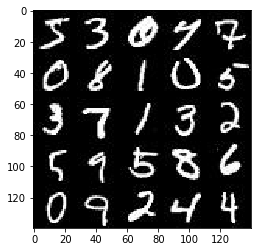

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

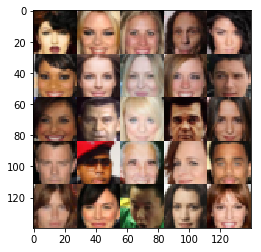

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


/Users/masahiro/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32,
                                  [None, image_width, image_height, image_channels],
                                  name='input_images')
    z = tf.placeholder(tf.float32, [None, z_dim], name='z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/Users/masahiro/anaconda/envs/tensorflow/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/Users/masahiro/anaconda/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/Users/masahiro/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/Users/masahiro/anaconda/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/Users/masahiro/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.in

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    def leaky_relu(x, alpha=0.2):
        return tf.maximum(x, alpha * x)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 14x14x32
        conv1 = tf.layers.conv2d(images, filters=32, kernel_size=5, strides=2, padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = tf.nn.dropout(conv1, keep_prob=0.8)
        conv1 = leaky_relu(conv1)
        
        # 7x7x64
        conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size=5, strides=2, padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.nn.dropout(conv2, keep_prob=0.8)
        conv2 = leaky_relu(conv2)
        
        # 4x4x128
        conv3 = tf.layers.conv2d(conv2, filters=128, kernel_size=5, strides=2, padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.nn.dropout(conv3, keep_prob=0.8)
        conv3 = leaky_relu(conv3)
        
        flat = tf.reshape(conv3, (-1, 4 * 4 * 128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    def leaky_relu(x, alpha=0.2):
        return tf.maximum(x, alpha * x)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # 4x4x512
        conv1 = tf.layers.dense(z, 4 * 4 * 512)
        conv1 = tf.reshape(conv1, [-1, 4, 4, 512])
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = leaky_relu(conv1)
        
        # 7x7x256
        conv2 = tf.layers.conv2d_transpose(conv1, filters=256, kernel_size=4, strides=1, padding='valid')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = leaky_relu(conv2)
        
        # 14x14x128
        conv3 = tf.layers.conv2d_transpose(conv2, filters=128, kernel_size=5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = leaky_relu(conv3)
        
        # 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(conv3, filters=out_channel_dim,
                                            kernel_size=5, strides=2, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(d_model_real) * (1 - smooth),
            logits=d_logits_real
        ))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.zeros_like(d_model_fake),
            logits=d_logits_fake
        ))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(d_model_fake),
            logits=d_logits_fake
        ))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1) \
            .minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1) \
            .minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, width, height, _ = data_shape
    n_channels = len(data_image_mode)
    
    input_images, z, learning_rate_ = model_inputs(image_width=width,
                                                   image_height=height,
                                                   image_channels=n_channels,
                                                   z_dim=z_dim)
    d_loss, g_loss = model_loss(input_real=input_images,
                                input_z=z,
                                out_channel_dim=n_channels)
    d_train_opt, g_train_opt = model_opt(d_loss=d_loss,
                                         g_loss=g_loss,
                                         learning_rate=learning_rate_,
                                         beta1=beta1)
    
    print_every=10
    show_every=100
    
    global losses
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Adjust value range of input images (between -1 and 1)
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={input_images: batch_images,
                                                 z: batch_z,
                                                 learning_rate_: learning_rate})
                sess.run(g_train_opt, feed_dict={input_images: batch_images,
                                                 z: batch_z,
                                                 learning_rate_: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z: batch_z, input_images: batch_images})
                    train_loss_g = g_loss.eval({z: batch_z})
                    print('Epoch {}/{}...'.format(epoch_i + 1, epochs),
                          'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                          'Generator Loss: {:.4f}'.format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess=sess,
                                          n_images=25,
                                          input_z=z,
                                          out_channel_dim=n_channels,
                                          image_mode=data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.2133... Generator Loss: 0.5250
Epoch 1/2... Discriminator Loss: 0.9859... Generator Loss: 1.1233
Epoch 1/2... Discriminator Loss: 0.6880... Generator Loss: 1.7324
Epoch 1/2... Discriminator Loss: 0.7504... Generator Loss: 1.4495
Epoch 1/2... Discriminator Loss: 1.0395... Generator Loss: 1.0353
Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 1.0269
Epoch 1/2... Discriminator Loss: 0.9752... Generator Loss: 1.4597
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 1.5811
Epoch 1/2... Discriminator Loss: 0.7968... Generator Loss: 1.3815
Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 1.6514


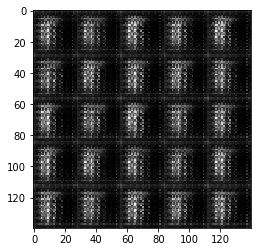

KeyboardInterrupt: 

In [11]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3121... Generator Loss: 7.8545
Epoch 1/1... Discriminator Loss: 0.5705... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 0.2218... Generator Loss: 2.4050
Epoch 1/1... Discriminator Loss: 0.0626... Generator Loss: 7.3249
Epoch 1/1... Discriminator Loss: 0.1487... Generator Loss: 5.9686
Epoch 1/1... Discriminator Loss: 0.3066... Generator Loss: 6.4322
Epoch 1/1... Discriminator Loss: 0.3108... Generator Loss: 8.5128
Epoch 1/1... Discriminator Loss: 0.7158... Generator Loss: 9.7165
Epoch 1/1... Discriminator Loss: 0.0685... Generator Loss: 6.8189
Epoch 1/1... Discriminator Loss: 0.1435... Generator Loss: 2.1929


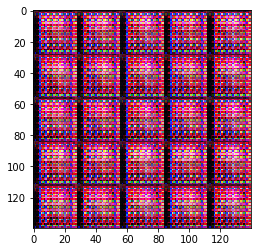

Epoch 1/1... Discriminator Loss: 2.9718... Generator Loss: 0.0587
Epoch 1/1... Discriminator Loss: 0.2887... Generator Loss: 2.2311
Epoch 1/1... Discriminator Loss: 0.0744... Generator Loss: 3.2877
Epoch 1/1... Discriminator Loss: 0.2778... Generator Loss: 1.8270
Epoch 1/1... Discriminator Loss: 0.3387... Generator Loss: 1.8210
Epoch 1/1... Discriminator Loss: 0.3512... Generator Loss: 1.7035
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 2.4125
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 2.6219... Generator Loss: 6.3483


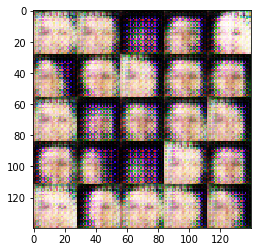

Epoch 1/1... Discriminator Loss: 1.6606... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.8794... Generator Loss: 0.3304
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.2066
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 1.5895
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 1.2923
Epoch 1/1... Discriminator Loss: 2.0681... Generator Loss: 3.1449
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 2.6580


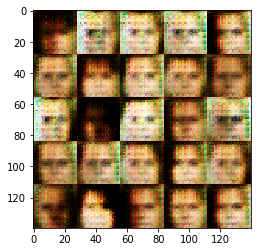

Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 1.8005
Epoch 1/1... Discriminator Loss: 0.2396... Generator Loss: 2.4447
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.3876
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.5109
Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 1.4181
Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 2.0772
Epoch 1/1... Discriminator Loss: 0.1590... Generator Loss: 2.6774
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 1.9602


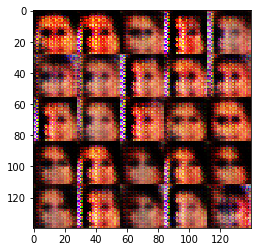

Epoch 1/1... Discriminator Loss: 0.3033... Generator Loss: 1.8416
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 4.4653
Epoch 1/1... Discriminator Loss: 0.4586... Generator Loss: 1.4886
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 3.7690
Epoch 1/1... Discriminator Loss: 0.3284... Generator Loss: 1.8235
Epoch 1/1... Discriminator Loss: 0.2006... Generator Loss: 2.6156
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 1.5734
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 1.1086


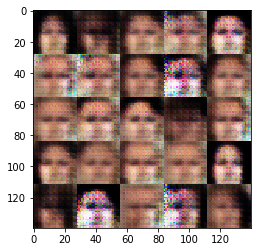

Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 1.2489
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.5644
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.3390
Epoch 1/1... Discriminator Loss: 0.3784... Generator Loss: 1.7219
Epoch 1/1... Discriminator Loss: 0.6783... Generator Loss: 1.5395
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.3738
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 1.4857


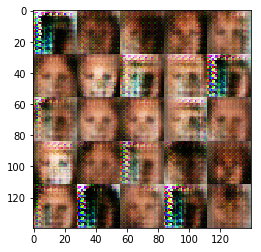

Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 1.9519
Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 1.2535
Epoch 1/1... Discriminator Loss: 0.4655... Generator Loss: 1.6566
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 1.2026
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 0.3784... Generator Loss: 1.6026
Epoch 1/1... Discriminator Loss: 0.3186... Generator Loss: 1.9418


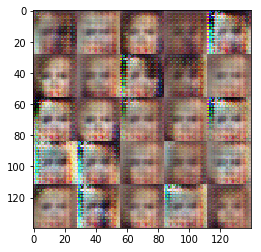

Epoch 1/1... Discriminator Loss: 0.2086... Generator Loss: 2.4896
Epoch 1/1... Discriminator Loss: 1.7971... Generator Loss: 4.0983
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 1.2597
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 1.5990
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.4289
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.7674


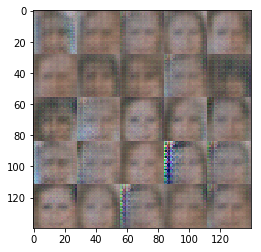

Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.4704
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.7703


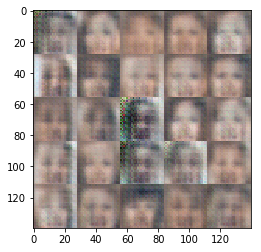

Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.7044


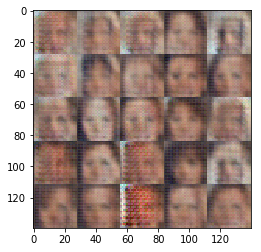

Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.0615


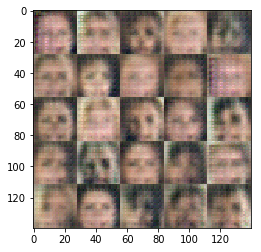

Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.6895


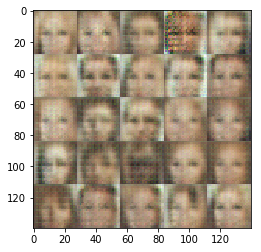

Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.1530
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.7557


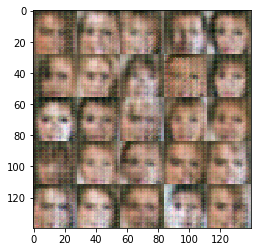

Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 1.2363
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.4812
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.5866


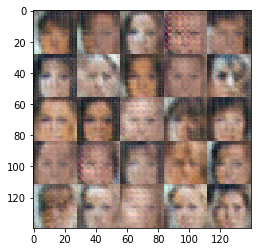

Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.3144
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 1.5157
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.0098


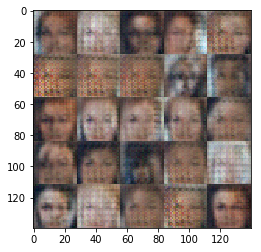

Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 1.2111
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 1.2421
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.8514


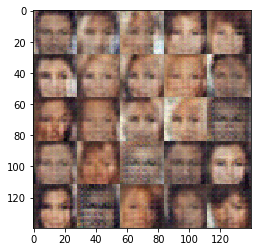

Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 1.4981
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 1.1529
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 1.1666
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 1.2864


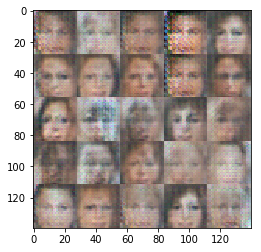

Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 1.4273
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.4676


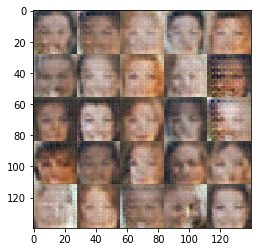

Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.8905


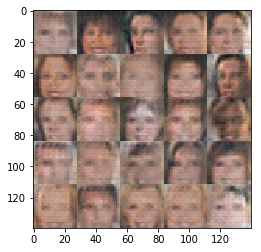

Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.5764... Generator Loss: 0.3550
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.2649
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 1.0627


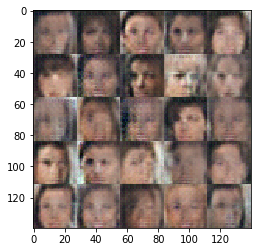

Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.8580


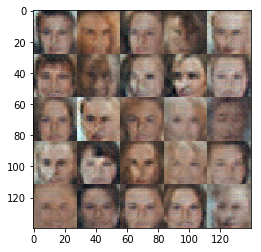

Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 1.4287
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.8771


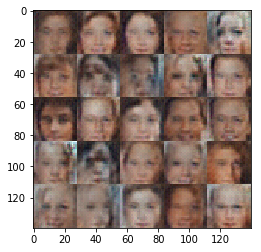

Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.4685
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.8469


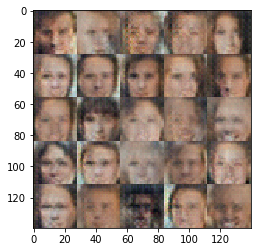

Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.7180


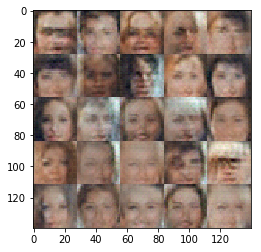

Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 0.9485


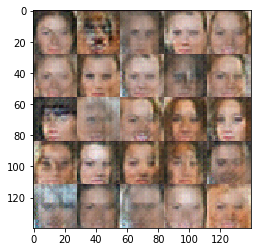

Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.4685
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.0303
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.7645


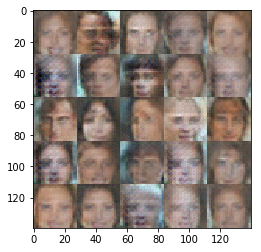

Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.8485


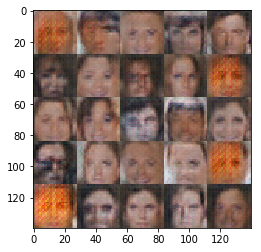

Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.4987
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 1.1471
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6803


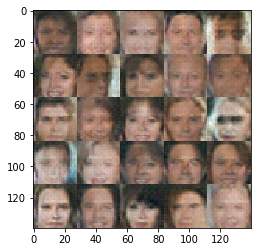

Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.7727


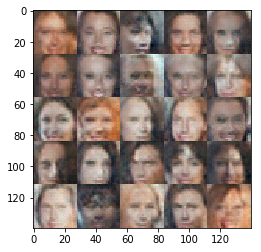

Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 1.1519
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.6477


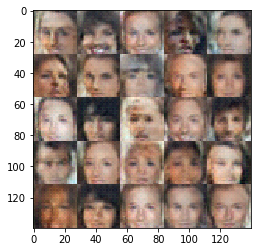

Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.7965


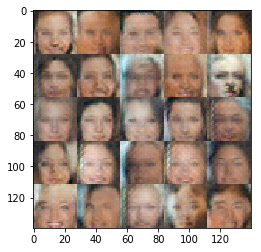

Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.8663


In [22]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.